<h1><center> PPOL 5203 Data Science I: Foundations <br><br> 
<font color='grey'> Working with Text as Data<br><br>
Tiago Ventura </center> <h1> 

---

## Learning Goals

This notebook will cover: 

- Unsupervised vs Supervised tasks with Text-as-Data 
- Unsupervised: 
    - Topic Models of Congressional Tweets
- Supervised: Sentiment Analysis
    - Dictionary
    - ML for Text-Classification
    - Working with Pre-trained Models - Transformers
    - Outsourcing to Generative Text-Based Models

## Unsupervised vs Supervised Tasks

The field of Natural Language Processing is strongly interwined with statistical learning. For this reasons, the lessons we covered on statistical learning form the foundation for the modelling approach we will take when analyzing text-as-data. As an example, the difference between unsupervised and supervised tasks we saw earlier in this course provides an useful analytical framework for us to separate distinct tasks when working with text. 

- **Supervised learning** consists on tasks in which for every observation $i$, we observe both inputs/predictors/features and outcomes we wish to predict. To solve this task, we use statistical learning on some sort of labeled data (outcomes), with a focus on maping inputs on outputs.

- On **Unsupervised tasks**, we only observe the input data, but our tasks do not use any type of outcome/label we wish to predict or explain. The goal of unsupervised learning is to recover hidden structures in the data, for example, clusters, groups, or topics based on the co-occurence of words. 

When working with text, supervised tasks often involve some sort of classification into known categories. For example, sentiment analysis, detection of stance, detection of spam, classification of social media posts containing toxic language or misinformation. These are all examples of supervised learning tasks. On the other side, unsupervised tasks are often used when the goal is to discover patterns in the text without having to make  assumptions about the content of the corpus. The most common type of unsupervised task is to find topics, or words that occur together in large volume of text. We know there is some hidden structure in the text, but we don't have the labels, so this becomes an unsupervised learning task. 

In this notebook, we will: 

- Use Topic Models to analyze a large set of Tweets from Members of the Congress. 
- Supervised classification task of sentiment analysis using a labelled dataset of IMDB Reviews. We will perform this task using four different methods: dictionaries, training ML models, using pre-trained models, and outsourcing to generative text-based models (ChatGPT under-the-hood model)

This notebook serves the purpose of providing you with the intuition behind these models in a super applied manner so that you can use them on your final projects. That is all to say, I will give you code, but will not explain in details the implementation of the models.  

## Topic Models

### Download the data 

Get the data [here](https://www.dropbox.com/scl/fi/tb67w3j2p6y3lmi186pzj/tweets_congress.csv?rlkey=k0wevbiru9tw4gyxvnkq3x1bm&dl=0)

In [1]:
# Open data
import pandas as pd
import numpy as np

tweets_data = pd.read_csv("tweets_congress.csv")
tweets_data.head()

,author,text,date,bios,retweet_author,Name,Link,State,Party,congress
0,AustinScottGA08,It is my team’s privilege to help our constitu...,Fri Dec 31 18:24:51 +0000 2021,I am proud to represent the 8th Congressional ...,NaN,"Scott, Austin",https://twitter.com/AustinScottGA08,GA,R,House
1,AustinScottGA08,I am proud to have sponsored this amendment wh...,Wed Dec 29 20:14:48 +0000 2021,I am proud to represent the 8th Congressional ...,NaN,"Scott, Austin",https://twitter.com/AustinScottGA08,GA,R,House
2,AustinScottGA08,"From my family to yours, we wish you peace, jo...",Sat Dec 25 16:48:16 +0000 2021,I am proud to represent the 8th Congressional ...,NaN,"Scott, Austin",https://twitter.com/AustinScottGA08,GA,R,House
3,AustinScottGA08,President Biden and Congress have a responsibi...,Wed Dec 22 19:14:13 +0000 2021,I am proud to represent the 8th Congressional ...,NaN,"Scott, Austin",https://twitter.com/AustinScottGA08,GA,R,House
4,AustinScottGA08,Happy second birthday to @SpaceForceDoD!\n\nSe...,Mon Dec 20 15:37:11 +0000 2021,I am proud to represent the 8th Congressional ...,NaN,"Scott, Austin",https://twitter.com/AustinScottGA08,GA,R,House


In [2]:
tweets_data.shape

(1266542, 10)

#### Pre-Processing Functions

In [4]:
## Pre processing steps
# stopwords
from nltk.corpus import stopwords

# tokenizer
from nltk.tokenize import word_tokenize

# lemmatizer
from nltk.stem import WordNetLemmatizer

# stemming
from nltk.stem.porter import PorterStemmer

## Topic Model: LDA Implementation

To estimate topic models, we will use the `gensim` library. `gensim` is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. It is the main library to retrieve pre-trained word embeddings, or to train word embeddings using the famous word2vec algorithm. 

This is a step-by-step of estimate LDA using `gensim`:


- **Preprocess the Text:** Follow most of the steps we saw before, including tokenization, removing stopwords, normalization, etc..

- **Create a dictionary:** gensim requires you to create a dictionary of all stemmed/preprocessed words in the corpus (collection of documents); the method `Dictionary` from `gensim` will crete this data structure for us. 

- **Filter out words from the dictionary that appear in either a very low proportion of documents (lower bound) or a very high proportion of documents (upper bound)**. 

- **Create a bag-of-words representation of the documents:** maps words from the dictionary representation to each document. 

- **Estimate the topic model**: use LDA model within gensim


In [26]:
# get a sample
import random
td = tweets_data.iloc[random.sample(range(1, tweets_data.shape[0]), 100000)].copy()


#### Step 1 - Pre-Processing

Write a function with all our previous steps

In [27]:
# Write a preprocessing function
def preprocess_text(text):
    
    # increase stop words
    stop_words = stopwords.words('english')
    stop_words = stop_words + ["http", "rt"]
    
    # tokenization 
    tokens_ = word_tokenize(text)
    
    # Generate a list of tokens after preprocessing
 
    # normalize
    tokens_ = [word.lower() for word in tokens_ if word.isalpha()]

    # stem and stopwords
    
    # instatiate the stemmer
    porter = PorterStemmer()

    tokens_ =  [porter.stem(word) for word in tokens_ if word not in stop_words]
    # Return the preprocessed tokens as a string
    return tokens_

In [28]:
# apply
td["tokens"] = td["text"].apply(preprocess_text)

#### Step 2: Create a Dictionary

In [29]:
# import dictionar
from gensim.corpora import Dictionary

# convert to a list
tokens = td["tokens"].tolist()

# let's look what this input is. 
# should be a list of list for each document split by tokens
tokens[1]

['epwgop',
 'today',
 'led',
 'colleagu',
 'introduc',
 'legisl',
 'would',
 'codifi',
 'navig',
 'water',
 'protect',
 'rule',
 'nwpr']

In [30]:
# Create a dictionary representation of the documents
dictionary = Dictionary(tokens)

# see
dictionary.token2id

{'america': 0,
 'constitut': 1,
 'ensur': 2,
 'govern': 3,
 'http': 4,
 'nation': 5,
 'preambl': 6,
 'right': 7,
 'secur': 8,
 'codifi': 9,
 'colleagu': 10,
 'epwgop': 11,
 'introduc': 12,
 'led': 13,
 'legisl': 14,
 'navig': 15,
 'nwpr': 16,
 'protect': 17,
 'rule': 18,
 'today': 19,
 'water': 20,
 'would': 21,
 'honor': 22,
 'part': 23,
 'project': 24,
 'speak': 25,
 'veteran': 26,
 'warrior': 27,
 'week': 28,
 'work': 29,
 'wound': 30,
 'american': 31,
 'davo': 32,
 'go': 33,
 'hear': 34,
 'pay': 35,
 'presid': 36,
 'senior': 37,
 'trump': 38,
 'worker': 39,
 'cyberthreat': 40,
 'easterli': 41,
 'face': 42,
 'hold': 43,
 'immedi': 44,
 'jen': 45,
 'nomin': 46,
 'real': 47,
 'businessman': 48,
 'countless': 49,
 'frustrat': 50,
 'function': 51,
 'invit': 52,
 'polit': 53,
 'stribopinion': 54,
 'success': 55,
 'back': 56,
 'stevescalis': 57,
 'amid': 58,
 'amp': 59,
 'care': 60,
 'case': 61,
 'coo': 62,
 'counti': 63,
 'covid': 64,
 'health': 65,
 'local': 66,
 'provid': 67,
 'recent'

#### Step 3: Filter out words

This is a additional pre-processing task. More meaningful topics comes when we remove rare and overly common words`

In [31]:
# Filter out words that occur in less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

#### Step 4: Create a bag-of-words representation of the documents

In [32]:
# Create a bag-of-words representation of the documents

# notice here you are just inputing every doc in a .doc2bow methods
corpus = [dictionary.doc2bow(doc) for doc in tokens]

In [35]:
# see case by case
# tuple with (id for every token, frequency) 
dictionary.doc2bow(tokens[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]

#### Step 5 - Fit the model

In [36]:
from gensim.models.ldamodel import LdaModel
# Train the LDA model
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    # this is your only input!!!
    num_topics=10,
    eval_every=False
)

### Visualizing results



In [37]:
# Print the Keyword in the 10 topics
lda_model.print_topics()

[(0,
  '0.026*"hear" + 0.020*"amp" + 0.015*"discuss" + 0.015*"today" + 0.014*"join" + 0.013*"morn" + 0.013*"watch" + 0.011*"member" + 0.010*"meet" + 0.010*"issu"'),
 (1,
  '0.025*"honor" + 0.025*"today" + 0.023*"amp" + 0.022*"thank" + 0.021*"women" + 0.020*"veteran" + 0.013*"serv" + 0.012*"nation" + 0.012*"join" + 0.010*"servic"'),
 (2,
  '0.028*"year" + 0.022*"happi" + 0.017*"nation" + 0.015*"job" + 0.013*"celebr" + 0.012*"month" + 0.012*"creat" + 0.011*"new" + 0.010*"day" + 0.010*"ago"'),
 (3,
  '0.044*"hous" + 0.038*"bill" + 0.036*"pass" + 0.033*"act" + 0.024*"vote" + 0.020*"bipartisan" + 0.018*"today" + 0.018*"senat" + 0.015*"health" + 0.015*"legisl"'),
 (4,
  '0.030*"school" + 0.018*"congression" + 0.017*"updat" + 0.016*"student" + 0.015*"de" + 0.014*"high" + 0.014*"district" + 0.014*"la" + 0.014*"offic" + 0.012*"amp"'),
 (5,
  '0.014*"presid" + 0.012*"must" + 0.012*"respons" + 0.011*"realdonaldtrump" + 0.011*"face" + 0.011*"step" + 0.010*"continu" + 0.008*"court" + 0.008*"chang" 

### Estimate Topic Prevalence

In [38]:
# Extract topics from each documenct
td['topic'] = [sorted(lda_model[corpus][text]) for text in range(len(td["text"]))]

# expand the dataframe
df_exploded = td["topic"].explode().reset_index()

# separate information
df_exploded[["topic", "probability"]] = pd.DataFrame(df_exploded['topic'].tolist(), index=df_exploded.index)


In [39]:
# data frame with the distribution for each topic vs document
df_exploded

,index,topic,probability
0,1027994,0,0.012501
1,1027994,1,0.012506
2,1027994,2,0.012505
3,1027994,3,0.012504
4,1027994,4,0.012501
...,...,...,...
766211,289464,5,0.014291
766212,289464,6,0.014292
766213,289464,7,0.208001
766214,289464,8,0.014293


In [40]:
# merge
df_exploded = pd.merge(df_exploded, td.reset_index(), on="index")

In [41]:
# topic prevalence
tp_prev = df_exploded.groupby("topic_x")["probability"].mean().reset_index()
tp_prev.sort_values("probability", ascending=False)

,topic_x,probability
6,6,0.163083
9,9,0.154156
8,8,0.145796
1,1,0.126339
7,7,0.123794
3,3,0.123058
0,0,0.122808
2,2,0.113937
5,5,0.112498
4,4,0.089949


### Bringing the words back

In [42]:
# Get the most important words for each topic
topic_words = list()
for i in range(lda_model.num_topics):
    # Get the top words for the topic
    words = lda_model.show_topic(i, topn=10)
    topic_words.append(", ".join([word for word, prob in words]))
      

In [43]:
topic_words

['hear, amp, discuss, today, join, morn, watch, member, meet, issu',
 'honor, today, amp, thank, women, veteran, serv, nation, join, servic',
 'year, happi, nation, job, celebr, month, creat, new, day, ago',
 'hous, bill, pass, act, vote, bipartisan, today, senat, health, legisl',
 'school, congression, updat, student, de, high, district, la, offic, amp',
 'presid, must, respons, realdonaldtrump, face, step, continu, court, chang, take',
 'amp, busi, great, today, thank, small, help, join, local, commun',
 'amp, secur, trump, need, must, letter, border, presid, nation, could',
 'day, get, one, today, make, vaccin, famili, know, safe, let',
 'american, care, biden, million, health, trump, peopl, famili, tax, presid']

In [44]:
tp_prev["words"] = topic_words

In [45]:
tp_prev

,topic_x,probability,words
0,0,0.122808,"hear, amp, discuss, today, join, morn, watch, ..."
1,1,0.126339,"honor, today, amp, thank, women, veteran, serv..."
2,2,0.113937,"year, happi, nation, job, celebr, month, creat..."
3,3,0.123058,"hous, bill, pass, act, vote, bipartisan, today..."
4,4,0.089949,"school, congression, updat, student, de, high,..."
5,5,0.112498,"presid, must, respons, realdonaldtrump, face, ..."
6,6,0.163083,"amp, busi, great, today, thank, small, help, j..."
7,7,0.123794,"amp, secur, trump, need, must, letter, border,..."
8,8,0.145796,"day, get, one, today, make, vaccin, famili, kn..."
9,9,0.154156,"american, care, biden, million, health, trump,..."


Very nice representation of the topics. you can merge this back with the core data set and see different distributions for candidates, parties, time of the day, any other group variable you have

### Visualizing Words

In [46]:
# preparing the dataframe

# convert topics to category
tp_prev['topic_x'] = tp_prev.topic_x.astype('category')

# get a list for ordering
topics = tp_prev["probability"].sort_values().index.tolist()

# create a new re-ordered variable
tp_prev = tp_prev.assign(topics_ord=
              tp_prev['topic_x'].cat.reorder_categories(topics))

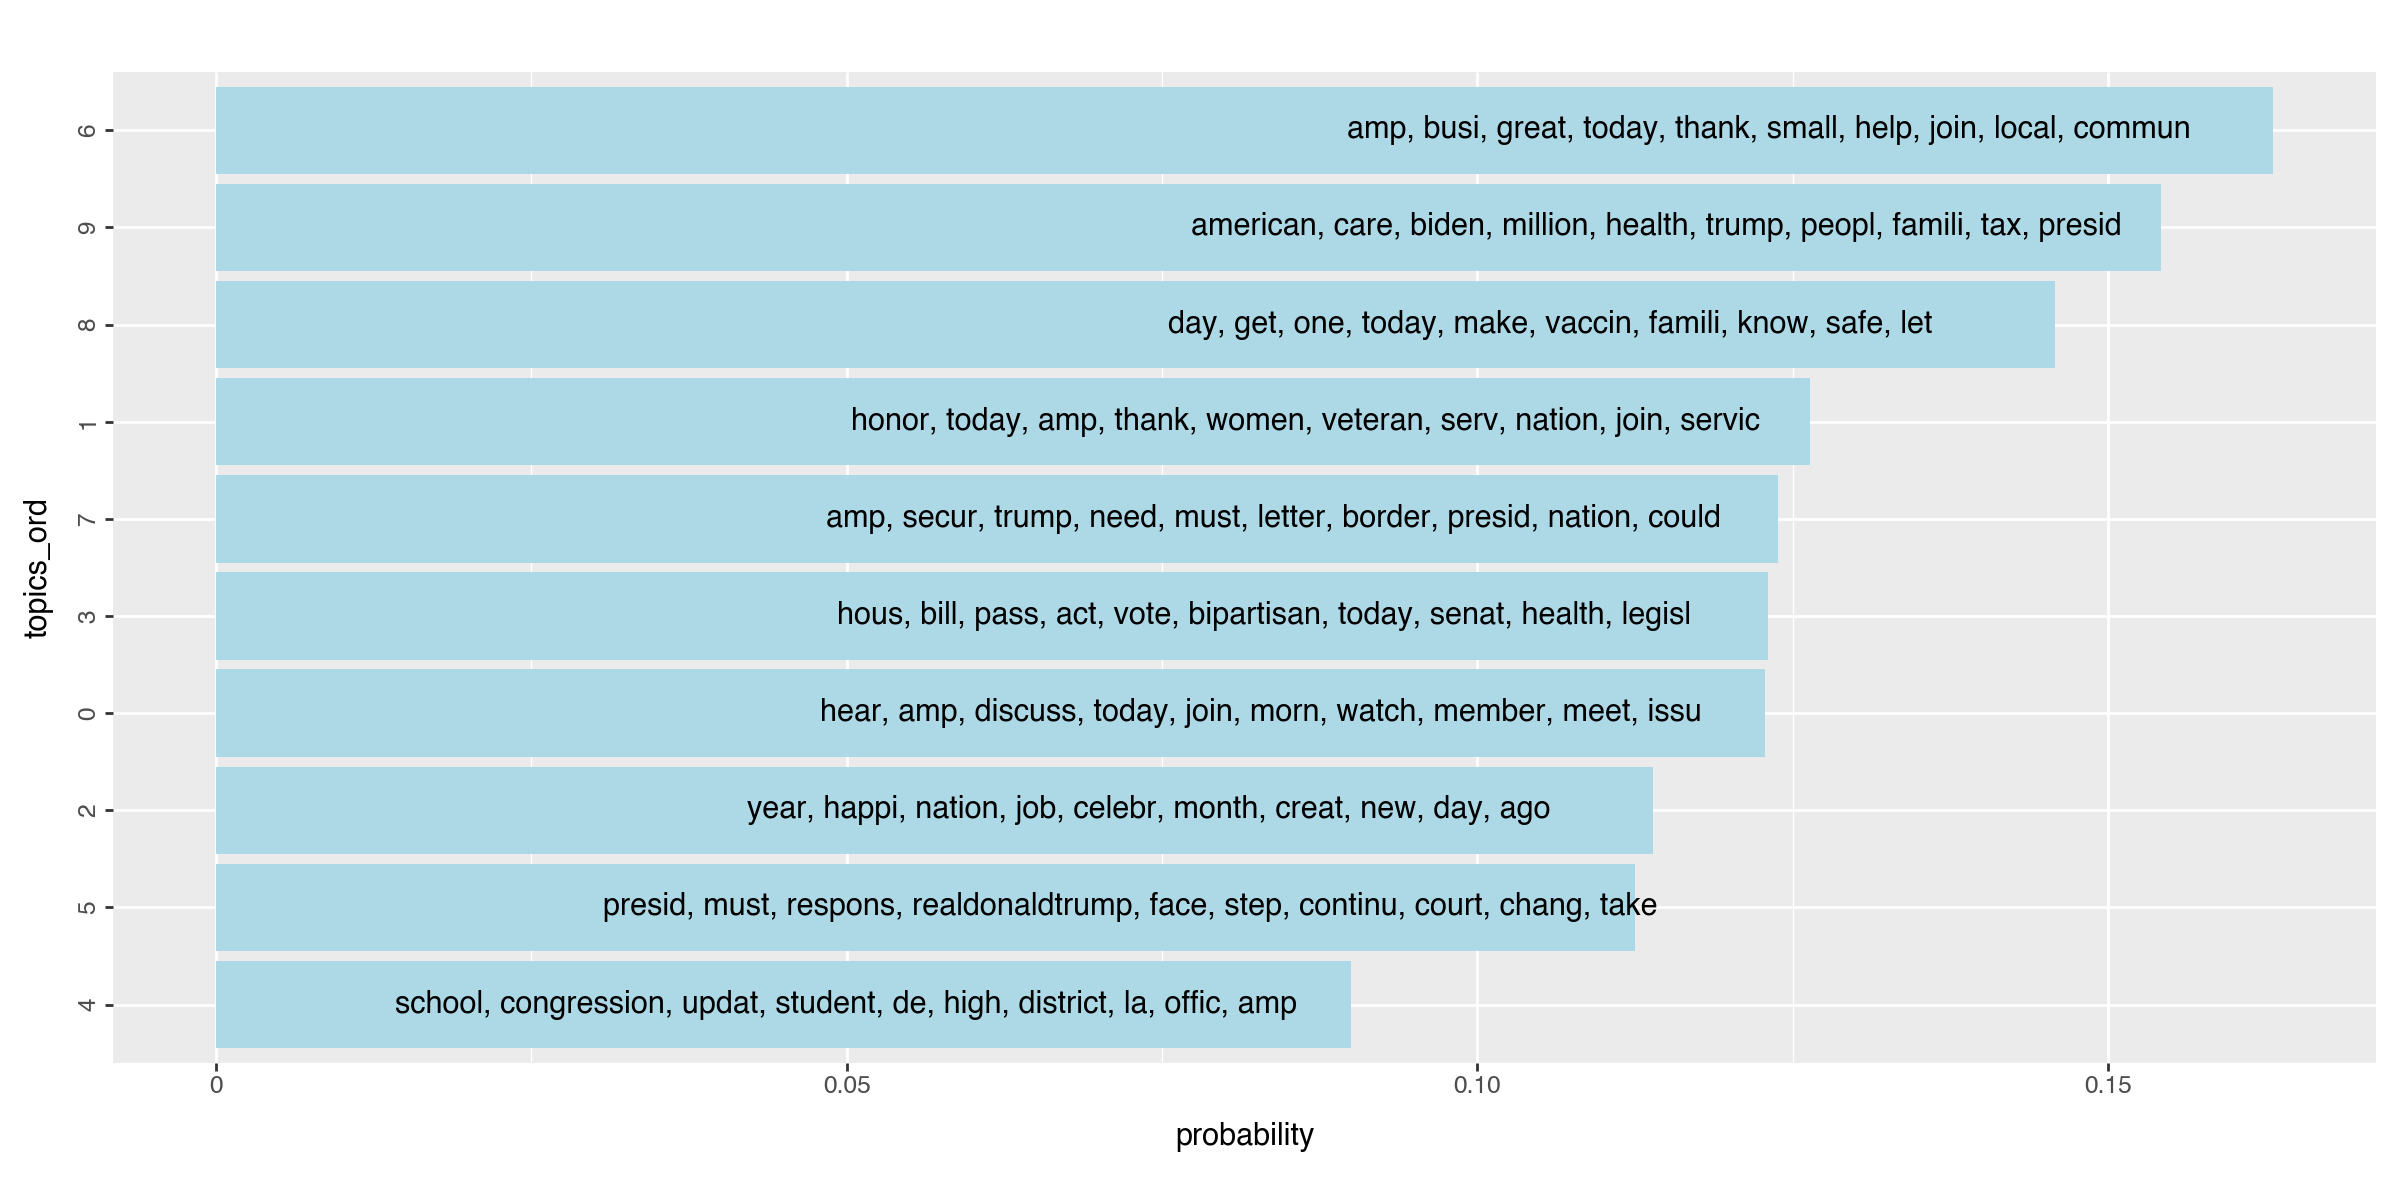

<Figure Size: (1200 x 600)>

In [47]:
# plot
from plotnine import *

(ggplot(tp_prev, aes(x='topics_ord', y='probability', label='words')) 
        + geom_col( fill='lightblue') 
        + coord_flip() 
        + geom_text(aes(y='probability + 0.01'), nudge_y=-.05)  # Adjusting text position
        + theme(axis_text_y=element_text(angle=90))  # Rotating x-axis labels for better visibility
        + theme(figure_size=(12, 6))
)
     

### Analyzing Model Coherence

How many topics should I use? As argued [here](https://web.stanford.edu/~gentzkow/research/text-as-data.pdf), to decide how many topics you should use, one needs to use both qualitative assessment of the topics (humans in the loop) and some coeherence measures across the topics. 

There are many coherence measures to be used to assess topic models and the quality of the topics. Broadly speaking, these measures all try to compare words that appear in the same topic and measures on average how similar they are compared to words from different topics. 

What matters here is for you to understand the procedure. In general, we fit many models with different number of topics, look at which point gains in these measures are very marginal, and then make qualitative assessments of how our topics look like. 

Let's see an example below using two measures (u_mass and c_v). On both cases, higher values means better topics

In [48]:
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,
    eval_every=False
)

In [49]:
from gensim.models import CoherenceModel

coherence_values = []
model_list = []
for num_topics in range(5, 30, 4):
    
    print(num_topics)
    
    # estimate the model
    model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
    
    # save the model
    model_list.append(model)
    
    # get coherence umass
    coherencemodel_umass = CoherenceModel(model=model, corpus=corpus, dictionary=dictionary, coherence='u_mass')

    # get another coherence measures
    coherencemodel_cv = CoherenceModel(model=model, texts=tokens, dictionary=dictionary, coherence='c_v')

    coherence_values.append((num_topics, coherencemodel_umass.get_coherence(), coherencemodel_cv.get_coherence()))


5
9
13
17
21
25
29


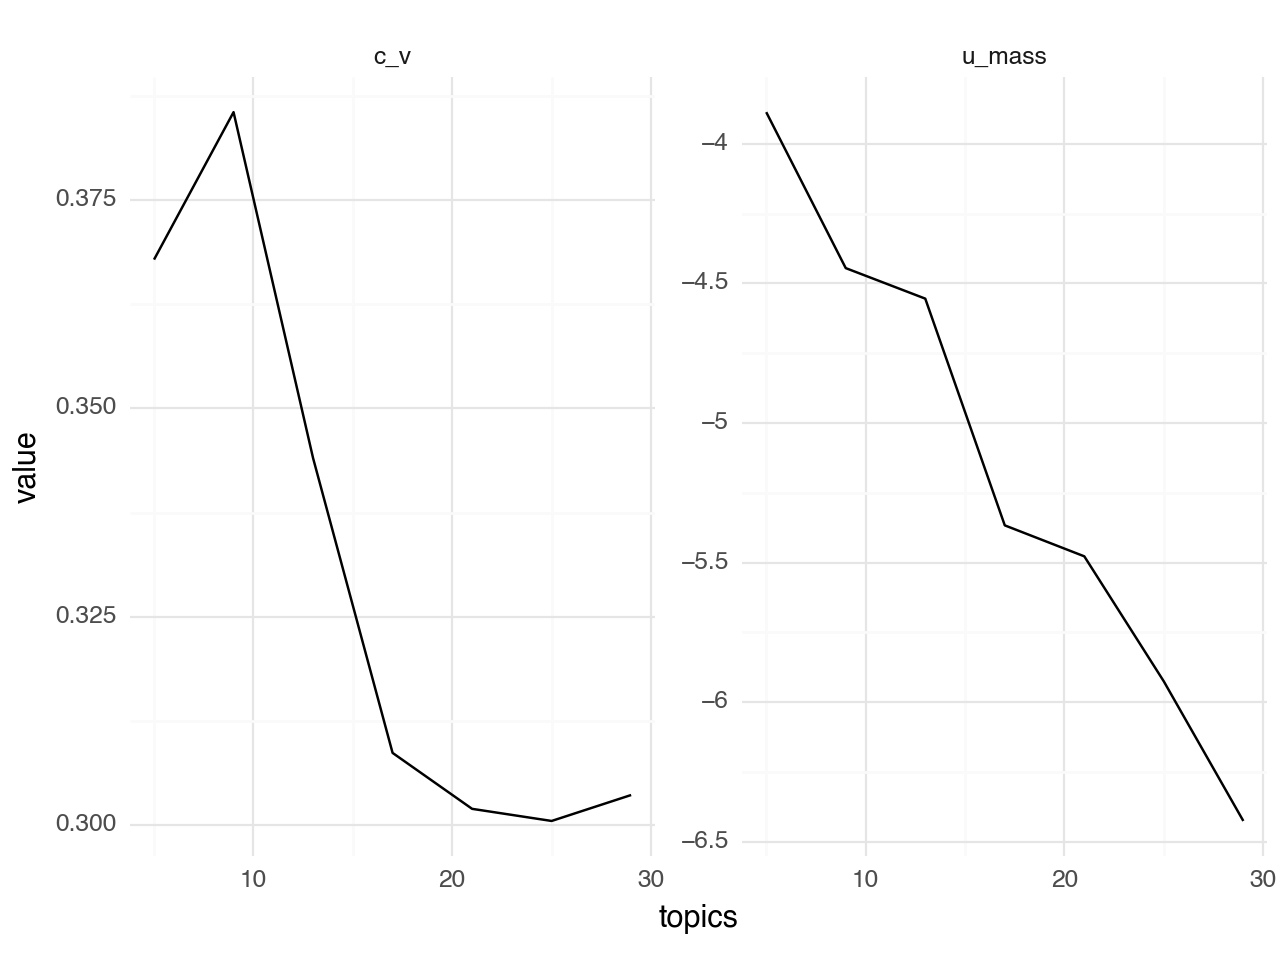

<Figure Size: (640 x 480)>

In [50]:
# grab the results
res = pd.DataFrame(coherence_values, columns=["topics", "u_mass", "c_v"])

# tidy
res = res.melt(id_vars="topics")

# plotnine
(ggplot(res, aes(y="value", x="topics"))
 + geom_line()
 + facet_wrap("variable", scales="free") 
 + theme_minimal())


### Practice

Repeate the code below. However, instead of using a random sample of tweets, run topic models on two samples. 

- A random sample of tweets from Democrats

- A random sample of tweets from Republicans

Compare the topics and discuss among yourselves the differences between Democrats and Republicans


## Supervised Learning with Text

To practice with supervised learning with text data, we will perform some classic sentiment analysis classification task. Sentiment analysis natural language processing technique that given a textual input (tweets, movie reviews, comments on a website chatbox, etc... ) identifies the polarity of the text. 

There are different flavors of sentiment analysis, but one of the most widely used techniques labels data into positive, negative and neutral. Other options are classifying text according to the levels of toxicity, which I did in the paper I asked you to read, or more fine-graine measures of sentiments. 

Sentiment analysis is just one of many types of classification tasks that can be done with text. For any type of task in which you need to identify if the input pertains to a certain category, you can use a similar set of tools as we will see for sentiment analysis. For example, these are some classification tasks I have used in my work before: 

- Classify the levels of toxicity in social media live-streaming comments.
- Analyze the sentiment of tweets.
- Classify if the user is a Republican or Democrat  given the their Twitter bios. 
- Identify if a particular social media post contains misinformation. 

For all these tasks, you need: 

- some type of labelled data (which you and your research team will do), 
- build/or use a pre-trained machine learning models to make the prediction
- evaluate the performance of the models

Here, we will work with data that was alread labelled for us. We will analyze the sentiment on IMDB dataset of reviews

### IMDB Dataset

For the rest of this notebook, we will IMDB dataset provided by [Hugging Face](https://huggingface.co/datasets/imdb). The IMDB dataset contains 25,000 movie reviews labeled by sentiment for training a model and 25,000 movie reviews for testing it. 

We will talk more about the Hugging Face project later in this notebook. For now, just download their main transformers library, and import the IMDB Review Dataset


#### Accessing the Dataset

In [56]:
#pip install -q transformers
from datasets import load_dataset
imdb = load_dataset("imdb")

Found cached dataset imdb (/Users/tb186/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

#### get a smaller sample


In [57]:
small_train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(3000))])
small_test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(300))])

Loading cached shuffled indices for dataset at /Users/tb186/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-9c48ce5d173413c7.arrow
Loading cached shuffled indices for dataset at /Users/tb186/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0/cache-c1eaa46e94dfbfd3.arrow


In [58]:
# convert to a dataframe
pd_train = pd.DataFrame(small_train_dataset)
pd_test = pd.DataFrame(small_test_dataset)

# see the data
pd_train.head()

,text,label
0,There is no relation at all between Fortier an...,1
1,This movie is a great. The plot is very true t...,1
2,"George P. Cosmatos' ""Rambo: First Blood Part I...",0
3,In the process of trying to establish the audi...,1
4,"Yeh, I know -- you're quivering with excitemen...",0


### Dictionary Methods

Our first approach for sentiment classification will use dictionary methods. 

**Common Procedure:** Consists on using a pre-determined set of words (dictionary) that identifies the categories you want to classify documents. With this dictionary, you can do a simple search through the documents, count how many times these words appear, and use some type of aggregation function to classify the text. For example: 

- Positive or negative, for sentiment
- Sad, happy, angry, anxious... for emotions
- Sexism, homophobia, xenophobia, racism... for hate speech

Dictionaries are the most basic strategy to classify documents. Its simplicity requires some unrealistic assumptions (for example related to ignoring contextual information of the documents). However, the use of dicitionaries have one major advantage: it allows for a bridge between qualititative and quantitative knowledge. You need human experts to build good dictionaries.  

#### VADER

There are many options for dictionaries for sentiment classification. We will use one popular open-source option available at NLTK: The VADER dictionary. VADER stands for Valence Aware Dictionary for Sentiment Reasoning. It is a model used for text sentiment analysis that is sensitive to both polarity (positive/negative) and intensity (strength) of emotion, and it was developed to handling particularly social media content. 


**Key Components of the VADER Dictionary:***

- Sentiment Lexicon: This is a list of known words and their associated sentiment scores. 

- Sentiment Intensity Scores: Each word in the lexicon is assigned a score that ranges from -4 (extremely negative) to +4 (extremely positive). 

- Handling of Contextual and Qualitative Modifiers: VADER is sensitive to both intensifiers (e.g., "very") and negations (e.g., "not"). 

You can read the original paper that created the VADER [here](https://www.google.com/search?q=ADER%3A+A+Parsimonious+Rule-based+Model+for+Sentiment+Analysis+of+Social+Media+Text.+Eighth+International+Conference+on+Weblogs+and+Social+Media&rlz=1C5GCEM_enUS1072US1073&oq=ADER%3A+A+Parsimonious+Rule-based+Model+for+Sentiment+Analysis+of+Social+Media+Text.+Eighth+International+Conference+on+Weblogs+and+Social+Media&gs_lcrp=EgZjaHJvbWUyBggAEEUYOTIGCAEQRRg60gEHMTU2ajBqNKgCALACAA&sourceid=chrome&ie=UTF-8)




In [51]:
#### Import dictionary
import nltk
# nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [52]:
# instantiate the model
sid = SentimentIntensityAnalyzer()

In [53]:
# simple example
review1 = "Oh, I loved the Data Science I course. The best course I have ever done!"

# classify
sid.polarity_scores(review1)

{'neg': 0.0, 'neu': 0.544, 'pos': 0.456, 'compound': 0.8553}

In [54]:
# simple example
review2 = "DS I was ok. Professor Ventura jokes were not great"

# classify
sid.polarity_scores(review2)

{'neg': 0.244, 'neu': 0.445, 'pos': 0.311, 'compound': -0.0243}

Let's now apply the dictionary at scale in our IMDB review dataset

In [59]:
# apply the dictionary to your data frame
pd_test["vader_scores"]=pd_test["text"].apply(sid.polarity_scores)

In [60]:
# let's see
pd_test.head()

,text,label,vader_scores
0,<br /><br />When I unsuspectedly rented A Thou...,1,"{'neg': 0.069, 'neu': 0.788, 'pos': 0.143, 'co..."
1,This is the latest entry in the long series of...,1,"{'neg': 0.066, 'neu': 0.862, 'pos': 0.073, 'co..."
2,This movie was so frustrating. Everything seem...,0,"{'neg': 0.24, 'neu': 0.583, 'pos': 0.177, 'com..."
3,"I was truly and wonderfully surprised at ""O' B...",1,"{'neg': 0.075, 'neu': 0.752, 'pos': 0.173, 'co..."
4,This movie spends most of its time preaching t...,0,"{'neg': 0.066, 'neu': 0.707, 'pos': 0.227, 'co..."


In [61]:
# grab final sentiment
pd_test["sentiment_vader"]=pd_test["vader_scores"].apply(lambda x: np.where(x["compound"] > 0, 1, 0))

Now that we have performed the classification task, we can see compare the labels and our predictions. We will be using a simple accuracy measure of how many labels were correctly classified

In [62]:
pd_test['vader_scores']

0      {'neg': 0.069, 'neu': 0.788, 'pos': 0.143, 'co...
1      {'neg': 0.066, 'neu': 0.862, 'pos': 0.073, 'co...
2      {'neg': 0.24, 'neu': 0.583, 'pos': 0.177, 'com...
3      {'neg': 0.075, 'neu': 0.752, 'pos': 0.173, 'co...
4      {'neg': 0.066, 'neu': 0.707, 'pos': 0.227, 'co...
                             ...                        
295    {'neg': 0.059, 'neu': 0.812, 'pos': 0.129, 'co...
296    {'neg': 0.056, 'neu': 0.87, 'pos': 0.074, 'com...
297    {'neg': 0.056, 'neu': 0.825, 'pos': 0.119, 'co...
298    {'neg': 0.092, 'neu': 0.768, 'pos': 0.14, 'com...
299    {'neg': 0.083, 'neu': 0.785, 'pos': 0.132, 'co...
Name: vader_scores, Length: 300, dtype: object

In [63]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(pd_test['label'], pd_test['sentiment_vader'])

# see
print(accuracy)

0.6966666666666667


### Training a Machine Learning Classifier

The next step to try if your dictionary is not working well is to train your own machine learning classifier. To build a simple Machine Learning classifier you will need to combine two different processes: 

- Build your input: here you will do all the steps we saw before  to convert text to numbers. The goal here is to use a document feature matrix as the input for the ML model. 

- Use `sklearn` to train your model and assess its accuracy. 

As before, let's not dig deep on the differences between each model.  We will learn how to train a model using a logistic regression with penalized terms. You can use the same code with `sklearn` to try different models. 

### Building you input

In [64]:
# apply the same pre-process function we used for topic models
# notice we are working with the training data
pd_train["tokens"] = pd_train["text"].apply(preprocess_text)

# let's see
pd_train.head()

,text,label,tokens
0,There is no relation at all between Fortier an...,1,"[relat, fortier, profil, fact, polic, seri, vi..."
1,This movie is a great. The plot is very true t...,1,"[movi, great, plot, true, book, classic, writt..."
2,"George P. Cosmatos' ""Rambo: First Blood Part I...",0,"[georg, cosmato, rambo, first, blood, part, ii..."
3,In the process of trying to establish the audi...,1,"[process, tri, establish, audienc, empathi, ja..."
4,"Yeh, I know -- you're quivering with excitemen...",0,"[yeh, know, quiver, excit, well, secret, live,..."


In [65]:
# Repeate for test
pd_test["tokens"] = pd_test["text"].apply(preprocess_text)

In [66]:
# join all
pd_train["tokens"] = pd_train["tokens"].apply(' '.join)
pd_test["tokens"] = pd_test["tokens"].apply(' '.join)

In [67]:
# lets build our document feature matrix using Tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

# instantiate a vectorizer
vectorizer = TfidfVectorizer()

# get tfidf
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    min_df=5, max_df=.90
)

# transform
train_tfidf = vectorizer.fit_transform(pd_train["tokens"]) # transform train
test_tfidf = vectorizer.transform(pd_test["tokens"]) # transform test

# check
print(train_tfidf.shape)
print(test_tfidf.shape)


(3000, 5607)
(300, 5607)


In [68]:
pd_train

,text,label,tokens
0,There is no relation at all between Fortier an...,1,relat fortier profil fact polic seri violent c...
1,This movie is a great. The plot is very true t...,1,movi great plot true book classic written mark...
2,"George P. Cosmatos' ""Rambo: First Blood Part I...",0,georg cosmato rambo first blood part ii pure u...
3,In the process of trying to establish the audi...,1,process tri establish audienc empathi jake roe...
4,"Yeh, I know -- you're quivering with excitemen...",0,yeh know quiver excit well secret live dentist...
...,...,...,...
2995,"""Boom"" has garnered itself a something of a re...",0,boom garner someth reput heavyweight taylor bu...
2996,1993 was the year. This was long before Philli...,0,year long phillip seymour thoma oscar knew wou...
2997,Comparison with American Graffiti is inevitabl...,0,comparison american graffiti inevit save money...
2998,"Can I please say first of all, that I felt so ...",0,pleas say first felt strongli movi sign imdb s...


In [69]:
# separate the targer
y_train = pd_train["label"]
y_test = pd_test["label"]

### Train your model

In [70]:
# import the models
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# train the model
model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
model.fit(train_tfidf,y_train)

LogisticRegression(penalty='l1', random_state=42, solver='liblinear')

In [71]:
# assess the model
y_pred = model.predict(test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.8366666666666667
Confusion Matrix:
 [[121  29]
 [ 20 130]]


Pretty cool accuracy!

## Practice

Modify the code above to try a different model. You can either use different parameters for the logistice regression or just try a different model. Did you do better than my baseline model? 

In [ ]:
# Your code here

## Pre-Trained Large Language Models: Hugging Face

In the past few years, the field of natural language processing  has undergone through a major revolution. As we first saw, the early generation of NLP models was based on the idea of converting text to numbers through the use of document-feature matrix relying on the bag-of-words assumptions. 

In the past ten-years, we have seen the emergence of a new paradigm using deep-learning and neural networks models to improve on the representation of text as numbers. These new models move away from the idea of a bag-of-words towards a more refined representation of text capturing the contextual meaning of words and sentences. This is achieved by training models with billions of parameters on text-sequencing tasks, using as inputs a dense representation of words. These are the famous word embeddings. 

The most recent innovation on this revolution has been the Transformers Models. These models use multiple embeddings (matrices) to represent word, in which each matrix can capture different contextual representations of words. This dynamic representation allow for higher predictive power on downstream tasks in which these matrices form the foundation of the entire machine learning architecture. For example, Transformers are the the core of the language models like Open AI's GPTs and Meta's LLaMa.

The Transformers use a sophisticated architecture that requires a huge amount of data and computational power to be trained. However, several of these models are open-sourced and are made available for us on the web through a platform called [Hugging Face](https://huggingface.co/). Those are what we call **pre-trained large language models**. At this point, there are thousands of pre-trained models based on the transformers framework available at hugging face. 

Once you find a model that fits your task, you have two options: 

- **Use the model architecture: access the model through the transformers library, and use it in you predictive tasks.** 

- **Fine-Tunning:** this is the most traditional way. You will get the model, give some data, re-train the model slightly so that the model will learn patterns from your data, and use on your predictive task. By fine-tuning a Transformers-based model for our own application, we can improve contextual understanding and therefore task-specific performance

We will see example of the first for sentiment analysis. If you were to do build a full pipeline for classification, you would probably need to fine-tune the model. To learn more about fine-tunning, I suggest you to read: 

- here on hugging face: https://huggingface.co/blog/sentiment-analysis-python

- and this forthcoming paper for political science applications:https://joantimoneda.netlify.app/files/Timoneda%20Vallejo%20V%20JOP.pdf

### Transformers Library

To use a model available on hugging face, you only need a few lines of code. 

In [72]:
# import the pipeline function
from transformers import pipeline

Use the pipeline class to access the model. The pipeline function will give you the default model for this task, that in thsi case is a Bert-Based Model, see here: https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english?text=I+like+you.+I+love+you

In [73]:
# instantiate your model
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Xformers is not installed correctly. If you want to use memorry_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [74]:
# see simple cases
print(review1, review2)

Oh, I loved the Data Science I course. The best course I have ever done! DS I was ok. Professor Ventura jokes were not great


In [75]:
#prediction
sentiment_pipeline([review1, review2])

[{'label': 'POSITIVE', 'score': 0.9998651742935181},
 {'label': 'NEGATIVE', 'score': 0.6337755918502808}]

We can easily use this model to make predictions on our entire dataset

In [77]:
# predict in the entire model. 
# notice here I am truncating the model. Transformers can only deal with 512 tokens max
pd_test["bert_scores"]=pd_test["text"].apply(sentiment_pipeline, truncation=True, max_length=512)

In [78]:
# let's clean it up
pd_test["bert_class"]=pd_test["bert_scores"].apply(lambda x: np.where(x[0]["label"]=="POSITIVE", 1, 0))

In [79]:
pd_test.head()

,text,label,vader_scores,sentiment_vader,tokens,bert_scores,bert_class
0,<br /><br />When I unsuspectedly rented A Thou...,1,"{'neg': 0.069, 'neu': 0.788, 'pos': 0.143, 'co...",1,br br unsuspectedli rent thousand acr thought ...,"[{'label': 'POSITIVE', 'score': 0.998875796794...",1
1,This is the latest entry in the long series of...,1,"{'neg': 0.066, 'neu': 0.862, 'pos': 0.073, 'co...",1,latest entri long seri film french agent frenc...,"[{'label': 'POSITIVE', 'score': 0.996983110904...",1
2,This movie was so frustrating. Everything seem...,0,"{'neg': 0.24, 'neu': 0.583, 'pos': 0.177, 'com...",0,movi frustrat everyth seem energet total prepa...,"[{'label': 'NEGATIVE', 'score': 0.997244238853...",0
3,"I was truly and wonderfully surprised at ""O' B...",1,"{'neg': 0.075, 'neu': 0.752, 'pos': 0.173, 'co...",1,truli wonder surpris brother art thou video st...,"[{'label': 'NEGATIVE', 'score': 0.649214446544...",0
4,This movie spends most of its time preaching t...,0,"{'neg': 0.066, 'neu': 0.707, 'pos': 0.227, 'co...",1,movi spend time preach script make movi appar ...,"[{'label': 'NEGATIVE', 'score': 0.998503446578...",0


In [80]:
## accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(pd_test['label'], pd_test['bert_class'])
# see
print(accuracy)

0.87


Without any fine-tunning, we are already doing much, much better than dictionaries!

### Use contextual knowledge: Model Trained on Amazon Reviews

Since I do not want go to the in-depth process of fine-tunning your model, let's see if there are models on Hugging Face that were actually trained on a similar task: predicting reviews. 

Actually, there are many. See here: https://huggingface.co/models?sort=trending&search=sentiment+reviews

In [87]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# acessing the model
model = AutoModelForSequenceClassification.from_pretrained("MICADEE/autonlp-imdb-sentiment-analysis2-7121569")

# Acessing the tokenizer
tokenizer = AutoTokenizer.from_pretrained("MICADEE/autonlp-imdb-sentiment-analysis2-7121569")

In [88]:
# use in my model
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Run in the dataframe
pd_test["imdb_scores"]=pd_test["text"].apply(sentiment_pipeline, truncation=True, max_length=512)

In [89]:
# clean
pd_test["imdb_class"]=pd_test["imdb_scores"].apply(lambda x: np.where(x[0]["label"]=="positive", 1, 0))

In [91]:
## accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(pd_test['label'], pd_test['imdb_class'])
# see
print(accuracy)

0.97


### Outsourcing to Generative Text-Based Models

The last thing I will show you in class is the possibility of using ChatGPT as a classification tool. As you know, ChatGPT is an large language model (as we just saw) developed by OpenAI, based on the GPT architecture. The model was trained on a word-prediction task and it has blown the world by its capacity to engage in conversational interactions.

Some recent papers have shown ChatGPT exhbits a strong performance on downstream classification tasks, like sentiment analysis, even though the model has not been trained or even fine-tuned for this task. Read here:https://osf.io/preprints/psyarxiv/sekf5/

In this paper, there is availabe code in R on how to interact with ChatGPT API. The example I show you below pretty much converts their code to Python. You can see a nice video showing their R code here: https://www.youtube.com/watch?v=Mm3uoK4Fogc

The whole process requires us to have access to the Open AI API which allow us to query continously the GPT models. Notice, this is not free. You pay for every query. That being said, it is quite cheap. 

In [92]:
# load api key
# load library to get environmental files
import os
from dotenv import load_dotenv


# load keys from  environmental var
load_dotenv() # .env file in cwd
gpt_key = os.environ.get("gpt") 

In [93]:
import requests 

# define headers
headers = {
        "Authorization": f"Bearer {gpt_key}",
        "Content-Type": "application/json",
    }

# define gpt model
question = "Please, tell me more about the Data Science and Public Policy Program at Georgetown's McCourt School"

data = {
        "model": "gpt-3.5-turbo-0301",
        "temperature": 0,
        "messages": [{"role": "user", "content": question}]
    }



# send a post request
response = requests.post("https://api.openai.com/v1/chat/completions", 
                             json=data, 
                             headers=headers)
# convert to json
response_json = response.json()

In [94]:
## see the output
response_json

{'id': 'chatcmpl-8NNKfIhevxWi4aOxecDlP4jlgVO4T',
 'object': 'chat.completion',
 'created': 1700581925,
 'model': 'gpt-3.5-turbo-0301',
 'choices': [{'index': 0,
   'message': {'role': 'assistant',
    'content': "The Data Science and Public Policy Program at Georgetown's McCourt School is a unique program that combines the fields of data science and public policy. The program is designed to equip students with the skills and knowledge needed to use data science to solve complex policy problems.\n\nThe program is interdisciplinary in nature, drawing on expertise from the fields of statistics, computer science, economics, and political science. Students in the program learn how to collect, analyze, and interpret data to inform policy decisions.\n\nThe curriculum includes courses in data science, statistics, machine learning, and policy analysis. Students also have the opportunity to work on real-world policy projects, collaborating with government agencies, non-profit organizations, and 

Let's now write a function to query the api at scale

In [123]:
# Function to interact with the ChatGPT API
def hey_chatGPT(question_text, api_key):
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json",
    }

    data = {
        "model": "gpt-3.5-turbo-0301",
        "temperature": 0,
        "messages": [{"role": "user", "content": question_text}]
    }

    response = requests.post("https://api.openai.com/v1/chat/completions", 
                             json=data, 
                             headers=headers, timeout=5)
    
    response_json = response.json()
    return response_json['choices'][0]['message']['content'].strip()

In [122]:
import time
output = []
# Run a loop over your dataset of reviews and prompt ChatGPT
for i in range(len(pd_test)):
    try: 
        print(i)
        question = "Is the sentiment of this text positive, neutral, or negative? \
        Answer only with a number: 1 if positive, 0 if neutral or negative. \
        Here is the text: "
        text = pd_test.loc[i, "text"]
        full_question = question + str(text)
        output.append(hey_chatGPT(full_question, gpt_key))
    except:
        output.append(np.nan)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [124]:
# add as a column
pd_test["gpt_scores"] = pd.to_numeric(output)

In [128]:
pd_test2 = pd_test.dropna().copy()

In [129]:
# check accuracy
accuracy = accuracy_score(pd_test2['label'], pd_test2['gpt_scores'])
# see
print(accuracy)

0.8783269961977186


Pretty good results! Notice, we have no fine-tunning here. Just grabing results from the model!

In [131]:
!jupyter nbconvert _week_12_nlp_II.ipynb --to html --template classic

[NbConvertApp] Converting notebook _week_12_nlp_II.ipynb to html
[NbConvertApp] Writing 781397 bytes to _week_12_nlp_II.html
